<center>

## **Lab 2**

# **Classification**

</center>

### **Student information**

**Student's name**: Nguyễn Công Tuấn

**Student's ID**: 22127436

**Class** 22KHDL1

### **Self-evaluation of the assignment requirements**

<div align='center'>

| **No.** | **Details** | **Evaluation** |
| --- | --- | --- |
| 1 | Implement the *Decision Tree* and parameter tuning for `max_depth` and `criterion` | 100\% |
| 2 | Implement the *Ensemble Model: Random Forest* and experiment with `n_estimators`, `max_features` and `bootstrap`| 100\% |
| 3 | Implement the *Naive Bayes* (I run both Gaussian Naive Bayes and Bernoulli Naive Bayes) and experiment with `var_smoothing` for Gaussian Naive Bayes and `alpha` for Bernoulli Naive Bayes | 100 \% | 
| 4 | Implement the *Support Vector Machine* with different kernels (`linear`, `poly`, `rbf`. `sigmoid`) and experiment parameter tuning with `C` or `gamma` | 100\% |
| 5 | Implement the *Neural Network: Multilayer Perceptron* and experiment with `hidden_layer_sizes`, `activation functions` and `learning rate` | 100\% |
| 6 | Using various evaluation metrics: *Confusion Matrix*, *Accuracy*, *Precision*, *Recall*, *Specificity*, *F1 Score*, *ROC Curve and AUC Score* to compare | 100\% |
| 7 | Split the dataset into two subsets: a training set (70\%) and a test set (30\%) | 100\% | 
| 8 | Set `random_state` to ensure reproducibility | 100\% |
| 9 | Shuffle the data before splitting and split it in a stratified fashion | 100\% |
| 10 | Use grid search and bayesian optimization with cross-validation to perform hyperparameter optimization for each algorithm to identify the best parameters | 100\% |
| 11 | Document the parameters tested and the best combination found | 100\% |
| 12 | Evaluate each model, categorized by type: Performance Overview, Metrics for Positive and Negative Classes and Model Discrimination Ability | 100\% |
| 13 | Analyze the trade-offs between different algorithms | 100\% |
| 14 | Compare on evaluation metrics to identify the best-performing model | 100\% |
| 15 | Use the confusion matrix to analyze misclassifications and discuss potential behind reason | 100\% | 
| 16 | Compare runtime and scalability | 100\% |
| 17 | Recommend the best model(s) based on evaluation metrics, computational cost, and dataset characteristics. | 100\% |


</div>

In [1]:
# %pip install ucimlrepo 

In [2]:
from ucimlrepo import fetch_ucirepo 
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
adult = fetch_ucirepo(id=2) 

In [4]:
X = adult.data.features 
y = adult.data.targets 
  
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [5]:
X = pd.concat([X, y], axis=1)

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Data Cleaning**

In [6]:
X = X.replace('?', np.nan) # replace '?' with NaN

missing_data = X.isna().sum()
print("Missing data per column:\n", missing_data)

Missing data per column:
 age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64


In [7]:
X = X.fillna({"workclass": "Unknown", "occupation": "Unknown", "native-country": "Unknown"})

**Identification of Duplicate Records**

In [8]:
X = X.drop_duplicates(keep="first")

**Additional Data Cleaning Methods**

In [9]:
X = X.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

In [10]:
X['income'] = X['income'].replace({'>50k.': '>50k', '<=50k.': '<=50k'})

In [11]:
X['income'] = X['income'].map({'<=50k': 0, '>50k': 1})

# **Features Selection**

In [12]:
X_encoded = X.copy()

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.drop("income")

for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Step 1: Apply log transformation to capital-gain and capital-loss
X_encoded["capital-gain"] = np.log1p(X_encoded["capital-gain"])
X_encoded["capital-loss"] = np.log1p(X_encoded["capital-loss"])

# Step 2: Discretize / Binning numerical variables
for col in numerical_cols:
    if col in ["capital-gain", "capital-loss"]:
        # Compute unique bin edges to avoid duplicates
        bin_edges = sorted(set([-1, 0, 
                                X_encoded[col].quantile(0.25), 
                                X_encoded[col].quantile(0.5), 
                                X_encoded[col].quantile(0.75), 
                                X_encoded[col].max()]))

        X_encoded[col] = pd.cut(X_encoded[col], bins=bin_edges, labels=False, duplicates='drop')
    else:
        X_encoded[col] = pd.qcut(X_encoded[col], q=10, duplicates='drop', labels=False)

# Compute Mutual Information
def mutual_info(target, features):
    mi_scores = {}

    for col in features:
        joint = pd.crosstab(X_encoded[col], X_encoded[target])
        total = joint.values.sum()

        prob_x = joint.sum(axis=1).values / total  
        prob_y = joint.sum(axis=0).values / total  
        prob_xy = joint / total  

        mi = np.nansum(prob_xy * np.log2(prob_xy / (prob_x[:, np.newaxis] * prob_y ) + 1e-10))
        mi_scores[col] = mi

    return mi_scores

mi_scores = mutual_info("income", X_encoded.columns.drop("income"))

mi_df = pd.DataFrame(list(mi_scores.items()), columns=["Feature", "Mutual Information"])
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)

print("Mutual Information Scores:")
print(mi_df.to_string(index=False))


Mutual Information Scores:
       Feature  Mutual Information
  relationship            0.165409
marital-status            0.156963
           age            0.093383
     education            0.092127
    occupation            0.091894
 education-num            0.087221
hours-per-week            0.055459
  capital-gain            0.042762
           sex            0.036695
     workclass            0.022300
  capital-loss            0.011425
          race            0.008200
native-country            0.008165
        fnlwgt            0.000733


In [13]:
X = X.drop(columns=["fnlwgt", "race", "native-country"])

In [14]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Function to compute Cramér's V manually (for categorical features)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values 
    chi2 = np.sum((confusion_matrix - confusion_matrix.sum(axis=1, keepdims=True) * 
                   confusion_matrix.sum(axis=0, keepdims=True) / confusion_matrix.sum())**2 /
                   (confusion_matrix.sum(axis=1, keepdims=True) * confusion_matrix.sum(axis=0, keepdims=True) / confusion_matrix.sum()))
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r - 1, k - 1)) if min(r - 1, k - 1) > 0 else 0  

# Compute Pearson correlation for numerical features
numerical_corr = X_encoded[numerical_cols].corr()

# Compute Cramér’s V for categorical features
cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0 
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(X_encoded[col1], X_encoded[col2])

# Convert to numeric type
cramers_v_matrix = cramers_v_matrix.astype(float)


full_corr_matrix = pd.DataFrame(index=X_encoded.columns, columns=X_encoded.columns, dtype=float)

# Fill numerical correlation values
for col1 in numerical_cols:
    for col2 in numerical_cols:
        full_corr_matrix.loc[col1, col2] = numerical_corr.loc[col1, col2]

# Fill Cramér's V values for categorical features
for col1 in categorical_cols:
    for col2 in categorical_cols:
        full_corr_matrix.loc[col1, col2] = cramers_v_matrix.loc[col1, col2]

# Fill correlations between categorical & numerical using Pearson (since numeric encoding is used)
for col1 in categorical_cols:
    for col2 in numerical_cols:
        full_corr_matrix.loc[col1, col2] = X_encoded[col1].corr(X_encoded[col2])
        full_corr_matrix.loc[col2, col1] = full_corr_matrix.loc[col1, col2] 

print("Full Correlation Matrix (Numerical: Pearson, Categorical: Cramér's V):")
print(full_corr_matrix)

Full Correlation Matrix (Numerical: Pearson, Categorical: Cramér's V):
                     age  workclass  education  education-num  marital-status  \
age             1.000000   0.052968  -0.015176       0.030760       -0.263866   
workclass       0.052968   1.000000   0.100016      -0.045938        0.085458   
education      -0.015176   0.100016   1.000000       0.359652        0.090958   
education-num   0.030760  -0.045938   0.359652       1.000000       -0.069911   
marital-status -0.263866   0.085458   0.090958      -0.069911        1.000000   
occupation      0.006754   0.400082   0.186593       0.045096        0.131642   
relationship   -0.263416   0.100813   0.122585      -0.090672        0.488163   
sex             0.088073   0.151771   0.093309       0.009284        0.459477   
capital-gain    0.077221   0.012044   0.028944       0.125186       -0.043954   
capital-loss    0.056908  -0.004671   0.017654       0.080969       -0.033840   
hours-per-week  0.071322  -0.078086   

In [15]:
X = X.drop(columns=["workclass", "education", "sex", "relationship"])

# **Data Normalization**

In [16]:
def min_max_scaling(column, new_min=0, new_max=1):
    X_min = column.min()
    X_max = column.max()
    return (column - X_min) / (X_max - X_min) * (new_max - new_min) + new_min

X["age"] = min_max_scaling(X["age"])

In [17]:
def decimal_scaling(column):
    j = np.ceil(np.log10(column.abs().max()))  # Compute scaling factor
    return column / (10 ** j)

X["capital-gain"] = decimal_scaling(X["capital-gain"])
X["capital-loss"] = decimal_scaling(X["capital-loss"])

In [18]:
def z_score_standardization(column):
    return (column - column.mean()) / column.std()

X["education-num"] = z_score_standardization(X["education-num"])
X["hours-per-week"] = z_score_standardization(X["hours-per-week"])

In [19]:
X = pd.get_dummies(X, columns=['marital-status', 'occupation'], drop_first=True)

# **Classification algorithm implementation**

In [20]:
X

,age,education-num,capital-gain,capital-loss,hours-per-week,income,marital-status_married-af-spouse,marital-status_married-civ-spouse,marital-status_married-spouse-absent,marital-status_never-married,...,occupation_handlers-cleaners,occupation_machine-op-inspct,occupation_other-service,occupation_priv-house-serv,occupation_prof-specialty,occupation_protective-serv,occupation_sales,occupation_tech-support,occupation_transport-moving,occupation_unknown
0,0.301370,1.136584,0.02174,0.0,-0.034303,0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.452055,1.136584,0.00000,0.0,-2.213312,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.287671,-0.419681,0.00000,0.0,-0.034303,0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,0.493151,-1.197814,0.00000,0.0,-0.034303,0,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
4,0.150685,1.136584,0.00000,0.0,-0.034303,0,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,1.136584,0.00000,0.0,-0.357119,0,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
48838,0.643836,-0.419681,0.00000,0.0,-0.034303,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
48839,0.287671,1.136584,0.00000,0.0,0.772737,0,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
48840,0.369863,1.136584,0.05455,0.0,-0.034303,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
# Splitting data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['income']), X['income'], test_size=0.3, shuffle=True, stratify=X['income'], random_state=42)

## **Decision Tree**

- Use a *decision tree classifier* with the parameter tuning for `max depth` and `criterion` (e.g., gini, entropy)

In [22]:
# Define search space
search_space_dt = {
    'max_depth': Integer(3, 25),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
}

# Perform Bayesian Optimization
bayes_search_dt = BayesSearchCV(
    DecisionTreeClassifier(),
    search_space_dt,
    n_iter=20,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
bayes_search_dt.fit(X_train, y_train)

# Get best parameters
best_params_dt = bayes_search_dt.best_params_
best_max_depth_dt = best_params_dt['max_depth']
best_criterion_dt = best_params_dt['criterion']

print(f"Best Parameters (Bayesian Search): max_depth={best_max_depth_dt}, criterion={best_criterion_dt}")


Best Parameters (Bayesian Search): max_depth=8, criterion=gini


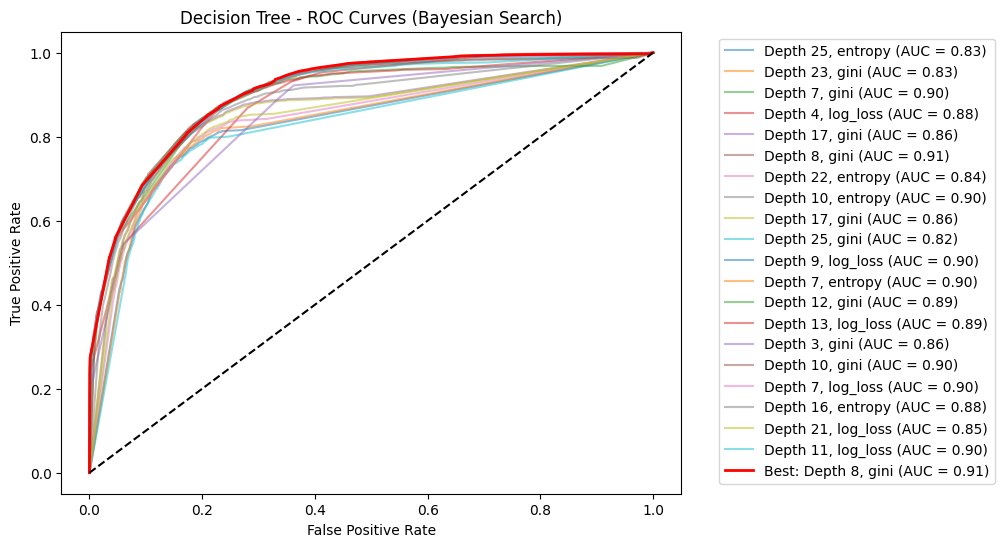

In [23]:
plt.figure(figsize=(8, 6))

all_models_dt = []
best_auc_dt = 0
best_fpr_dt, best_tpr_dt = None, None

for params in bayes_search_dt.cv_results_['params']:
    max_depth_dt = params['max_depth']
    criterion_dt = params['criterion']

    # Train model
    model_dt = DecisionTreeClassifier(max_depth=max_depth_dt, criterion=criterion_dt)
    model_dt.fit(X_train, y_train)

    # Predictions
    y_proba_dt = model_dt.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
    roc_auc = auc(fpr_dt, tpr_dt)

    all_models_dt.append((max_depth_dt, criterion_dt, fpr_dt, tpr_dt, roc_auc))

    # Highlight the best model
    if (max_depth_dt == best_max_depth_dt) and (criterion_dt == best_criterion_dt):
        best_auc = roc_auc
        best_fpr, best_tpr = fpr_dt, tpr_dt

    plt.plot(fpr_dt, tpr_dt, label=f"Depth {max_depth_dt}, {criterion_dt} (AUC = {roc_auc:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr, best_tpr, linewidth=2, label=f"Best: Depth {best_max_depth_dt}, {best_criterion_dt} (AUC = {best_auc:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [24]:
# Train the best model separately
start_time_dt = timer()
best_model_dt = DecisionTreeClassifier(max_depth=best_max_depth_dt, criterion=best_criterion_dt)
best_model_dt.fit(X_train, y_train)
training_time_dt = timer() - start_time_dt

# Predictions
y_pred_dt = best_model_dt.predict(X_test)
y_proba_dt = best_model_dt.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_decision_tree = confusion_matrix(y_test, y_pred_dt)
report_decision_tree = classification_report(y_test, y_pred_dt, output_dict=True)

# Specificity (True Negative Rate)
tn, fp, fn, tp = conf_matrix_decision_tree.ravel()
specificity = tn / (tn + fp)

# ROC Curve for best model
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

# Print Evaluation Results
print("\nDecision Tree Classification Report (Best Model):")
print(classification_report(y_test, y_pred_dt))
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Training Time: {training_time_dt:.4f} seconds")
print(f"ROC AUC: {roc_auc:.4f}")


Decision Tree Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     11138
           1       0.79      0.56      0.65      3506

    accuracy                           0.86     14644
   macro avg       0.83      0.76      0.78     14644
weighted avg       0.85      0.86      0.85     14644

Specificity (True Negative Rate): 0.9538
Training Time: 0.0615 seconds
ROC AUC: 0.9057


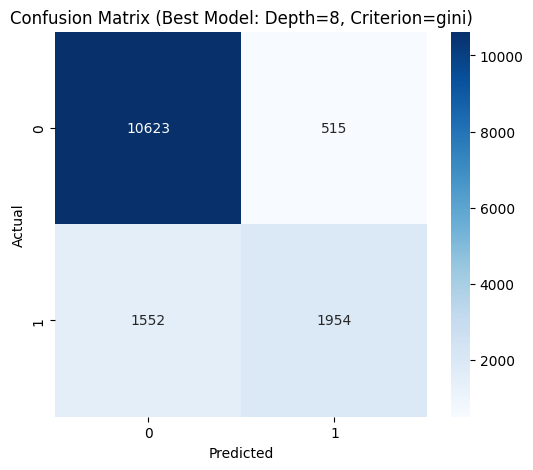

In [25]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_decision_tree, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: Depth={best_max_depth_dt}, Criterion={best_criterion_dt})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Ensemble Model: Random Forest**

- Build an ensemble of decision trees.
- Experiment with `n estimators`, `max features`, and `bootstrap`

In [26]:
# Define search space for Random Forest
search_space_rf = {
    'n_estimators': Integer(10, 500),  # Wider range
    'max_features': Categorical(['sqrt', 'log2', None, 0.1, 0.5]),
    'bootstrap': Categorical([True, False])
}

# Perform Bayesian Optimization
bayes_search_rf = BayesSearchCV(
    RandomForestClassifier(),
    search_space_rf,
    n_iter=10,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
bayes_search_rf.fit(X_train, y_train)

# Get best parameters
best_params_rf = bayes_search_rf.best_params_
best_n_estimators = best_params_rf['n_estimators']
best_max_features = best_params_rf['max_features']
best_bootstrap = best_params_rf['bootstrap']

print(f"Best Parameters (Bayesian Search - Random Forest): n_estimators={best_n_estimators}, max_features={best_max_features}, bootstrap={best_bootstrap}")

Best Parameters (Bayesian Search - Random Forest): n_estimators=303, max_features=0.5, bootstrap=True


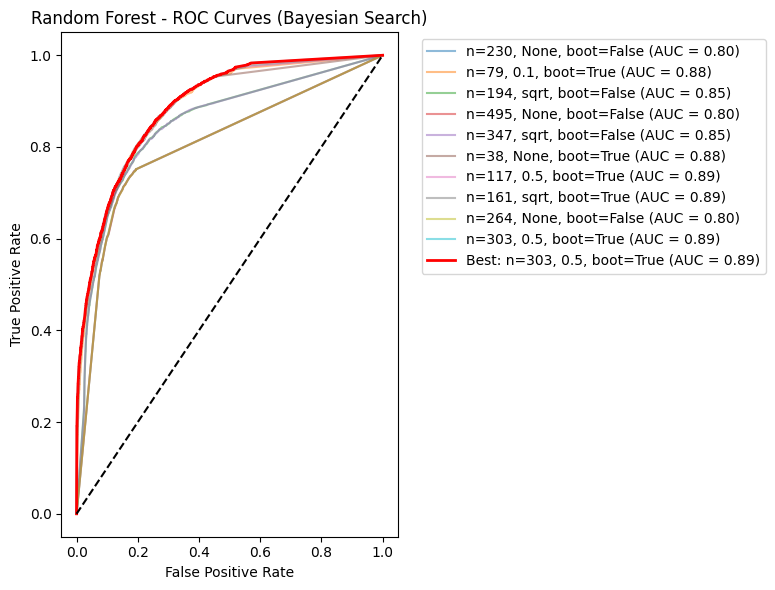

In [27]:
# Initialize plot
plt.figure(figsize=(8, 6))

all_models_rf = []
best_auc_rf = 0
best_fpr_rf, best_tpr_rf = None, None

for i, params in enumerate(bayes_search_rf.cv_results_['params']):
    n_estimators_rf = params['n_estimators']
    max_features_rf = params['max_features']
    bootstrap_rf = params['bootstrap']

    # Train model
    model_rf = RandomForestClassifier(n_estimators=n_estimators_rf, max_features=max_features_rf, bootstrap=bootstrap_rf)
    model_rf.fit(X_train, y_train)

    # Predictions
    y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    all_models_rf.append((n_estimators_rf, max_features_rf, bootstrap_rf, fpr_rf, tpr_rf, roc_auc_rf))

    # Plot with unique color for debugging
    plt.plot(fpr_rf, tpr_rf, label=f"n={n_estimators_rf}, {max_features_rf}, boot={bootstrap_rf} (AUC = {roc_auc_rf:.2f})", alpha=0.5)

    # Update best model variables if this is the best parameter set
    if (n_estimators_rf == best_n_estimators and 
        max_features_rf == best_max_features and 
        bootstrap_rf == best_bootstrap):
        best_auc_rf = roc_auc_rf
        best_fpr_rf = fpr_rf
        best_tpr_rf = tpr_rf

# Check if best_fpr_rf and best_tpr_rf are still None
if best_fpr_rf is None or best_tpr_rf is None:
    raise ValueError("Best model parameters were not found in the loop. Check bayes_search_rf.best_params_ and cv_results_['params'].")

# Plot the best model
plt.plot(best_fpr_rf, best_tpr_rf, linewidth=2, label=f"Best: n={best_n_estimators}, {best_max_features}, boot={best_bootstrap} (AUC = {best_auc_rf:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curves (Bayesian Search)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
# Train the best model separately
start_time_rf = timer()
best_model_rf = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, bootstrap=best_bootstrap)
best_model_rf.fit(X_train, y_train)
training_time_rf = timer() - start_time_rf

# Predictions
y_pred_rf = best_model_rf.predict(X_test)
y_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Specificity (True Negative Rate)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)

# ROC Curve for best model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Print Evaluation Results
print("\nRandom Forest Classification Report (Best Model):")
print(classification_report(y_test, y_pred_rf))
print(f"Specificity (True Negative Rate): {specificity_rf:.4f}")
print(f"Training Time: {training_time_rf:.4f} seconds")
print(f"ROC AUC: {roc_auc_rf:.4f}")


Random Forest Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11138
           1       0.70      0.63      0.66      3506

    accuracy                           0.85     14644
   macro avg       0.79      0.77      0.78     14644
weighted avg       0.84      0.85      0.84     14644

Specificity (True Negative Rate): 0.9147
Training Time: 17.3846 seconds
ROC AUC: 0.8904


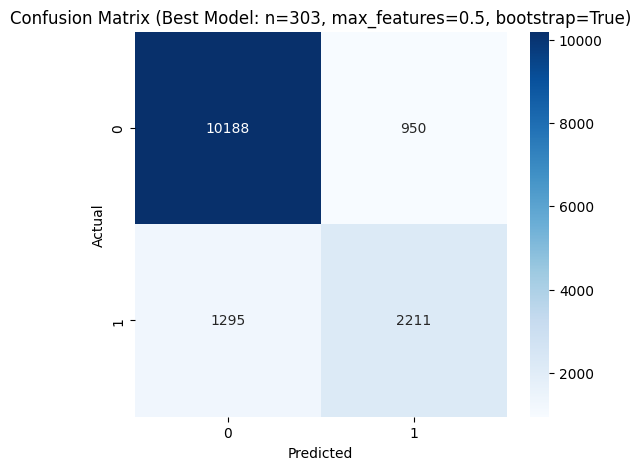

In [29]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: n={best_n_estimators}, max_features={best_max_features}, bootstrap={best_bootstrap})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Naive Bayes**

- Implement *Gaussian Naive Bayes* (or any other variants like *Bernoulli* or *Multinomial* if applicable to the dataset).
- Experiment with `var_smoothing` for *Gaussian* Naive Bayes or `alpha` for *Bernoulli* or *Multinomial Naive Bayes*

**Gaussian Naive Bayes**

In [30]:
# Separate numerical and binary features
num_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
binary_features = [col for col in X.columns if col not in num_features and col != 'income']

X_num = X[num_features]  # Continuous features
X_bin = X[binary_features]  # Binary features


In [31]:
# Define search space for Gaussian Naive Bayes
search_space_gnb = {'var_smoothing': Real(1e-9, 1e-3, prior='log-uniform')}

# Perform Bayesian Optimization
bayes_search_gnb = BayesSearchCV(
    GaussianNB(),
    search_space_gnb,
    n_iter=10,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

bayes_search_gnb.fit(X_train[num_features], y_train)  # Train using numerical features

# Get best parameters
best_var_smoothing = bayes_search_gnb.best_params_['var_smoothing']

print(f"Best Parameters (Bayesian Search - Gaussian NB): var_smoothing={best_var_smoothing:.1e}")

Best Parameters (Bayesian Search - Gaussian NB): var_smoothing=2.1e-05


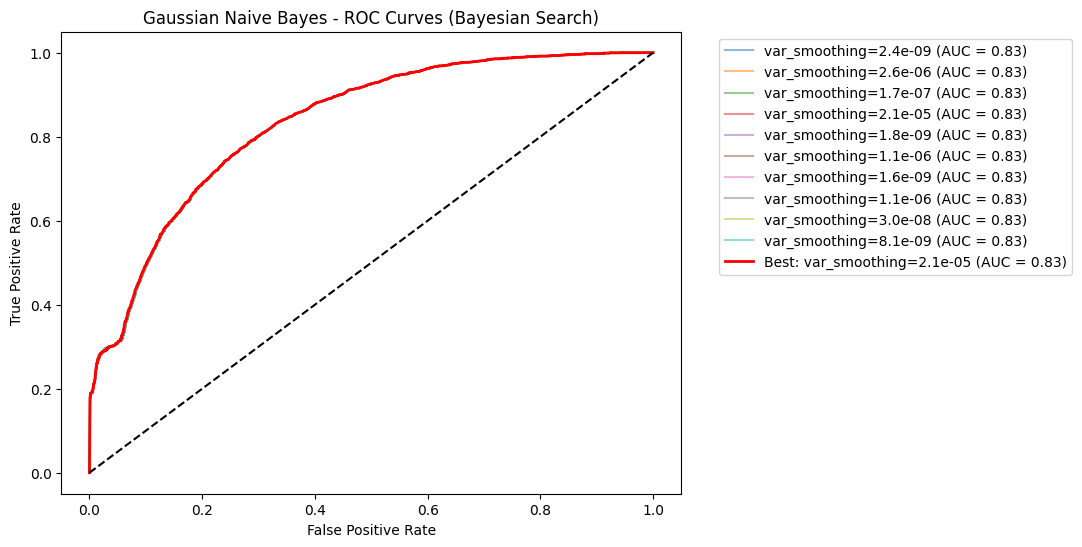

In [32]:
# Initialize plot
plt.figure(figsize=(8, 6))

all_models_gnb = []
best_auc_gnb = 0
best_fpr_gnb, best_tpr_gnb = None, None

for params in bayes_search_gnb.cv_results_['params']:
    var_smoothing_gnb = params['var_smoothing']

    # Train model
    model_gnb = GaussianNB(var_smoothing=var_smoothing_gnb)
    model_gnb.fit(X_train[num_features], y_train)

    # Predictions
    y_proba_gnb = model_gnb.predict_proba(X_test[num_features])[:, 1]

    # ROC Curve
    fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_proba_gnb)
    roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

    all_models_gnb.append((var_smoothing_gnb, fpr_gnb, tpr_gnb, roc_auc_gnb))

    # Highlight the best model
    if var_smoothing_gnb == best_var_smoothing:
        best_auc_gnb = roc_auc_gnb
        best_fpr_gnb, best_tpr_gnb = fpr_gnb, tpr_gnb

    plt.plot(fpr_gnb, tpr_gnb, label=f"var_smoothing={var_smoothing_gnb:.1e} (AUC = {roc_auc_gnb:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_gnb, best_tpr_gnb, linewidth=2, label=f"Best: var_smoothing={best_var_smoothing:.1e} (AUC = {best_auc_gnb:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [33]:
# Train the best model separately
start_time_gnb = timer()
best_gnb = GaussianNB(var_smoothing=best_var_smoothing)
best_gnb.fit(X_train[num_features], y_train)
training_time_gnb = timer() - start_time_gnb


# Predictions
y_pred_gnb = best_gnb.predict(X_test[num_features])
y_proba_gnb = best_gnb.predict_proba(X_test[num_features])[:, 1]

# Compute evaluation metrics
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
report_gnb = classification_report(y_test, y_pred_gnb, output_dict=True)

# Specificity (True Negative Rate)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = conf_matrix_gnb.ravel()
specificity_gnb = tn_gnb / (tn_gnb + fp_gnb)

# ROC Curve for best model
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_proba_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

# Print Evaluation Results
print("\nGaussian Naive Bayes Classification Report (Best Model):")
print(classification_report(y_test, y_pred_gnb))
print(f"Specificity (True Negative Rate): {specificity_gnb:.4f}")
print(f"Training Time: {training_time_gnb:.4f} seconds")
print(f"ROC AUC: {roc_auc_gnb:.4f}")


Gaussian Naive Bayes Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     11138
           1       0.66      0.31      0.42      3506

    accuracy                           0.80     14644
   macro avg       0.74      0.63      0.65     14644
weighted avg       0.78      0.80      0.77     14644

Specificity (True Negative Rate): 0.9507
Training Time: 0.0097 seconds
ROC AUC: 0.8334


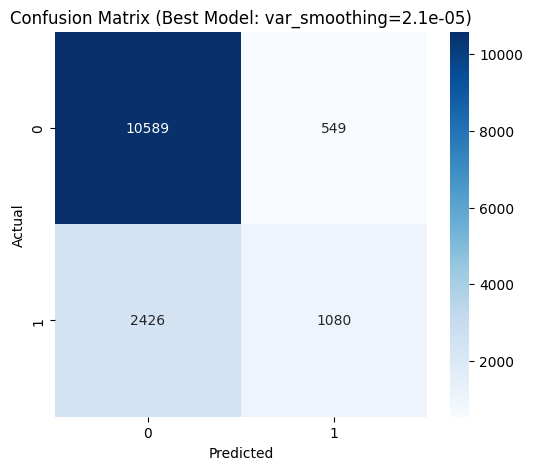

In [34]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: var_smoothing={best_var_smoothing:.1e})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Bernoulli Naive Bayes**

In [35]:
# Define search space for Bernoulli Naive Bayes
search_space_bnb = {'alpha': Real(0.01, 10, prior='log-uniform')}

# Perform Bayesian Optimization
bayes_search_bnb = BayesSearchCV(
    BernoulliNB(),
    search_space_bnb,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

bayes_search_bnb.fit(X_train[binary_features], y_train)  # Train using binary features

# Get best parameters
best_alpha_bnb = bayes_search_bnb.best_params_['alpha']

print(f"Best Parameters (Bayesian Search - Bernoulli NB): alpha={best_alpha_bnb:.2f}")

Best Parameters (Bayesian Search - Bernoulli NB): alpha=8.97


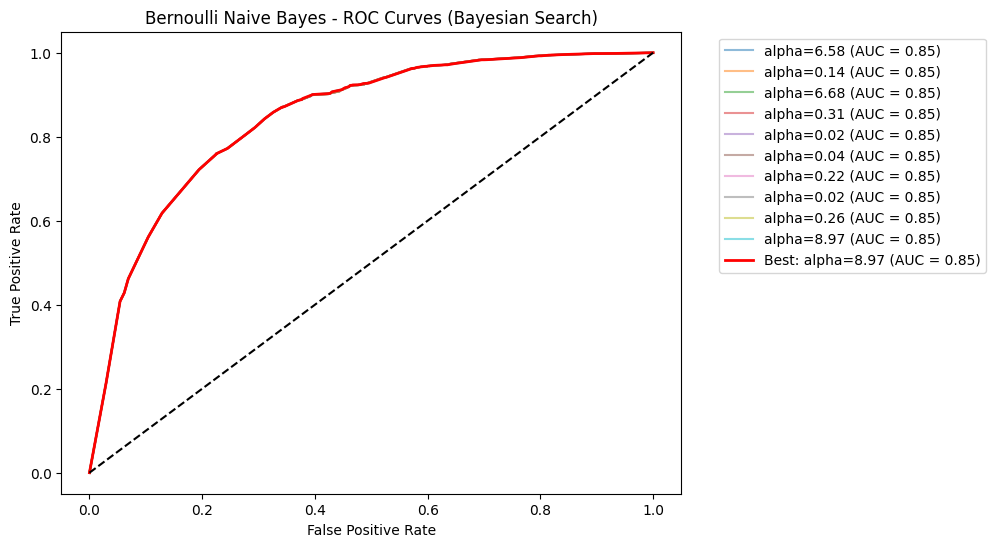

In [36]:
plt.figure(figsize=(8, 6))

all_models_bnb = []
best_auc_bnb = 0
best_fpr_bnb, best_tpr_bnb = None, None

for params in bayes_search_bnb.cv_results_['params']:
    alpha_bnb = params['alpha']

    # Train model
    model_bnb = BernoulliNB(alpha=alpha_bnb)
    model_bnb.fit(X_train[binary_features], y_train)

    # Predictions
    y_proba_bnb = model_bnb.predict_proba(X_test[binary_features])[:, 1]

    # ROC Curve
    fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_proba_bnb)
    roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

    all_models_bnb.append((alpha_bnb, fpr_bnb, tpr_bnb, roc_auc_bnb))

    # Highlight the best model
    if alpha_bnb == best_alpha_bnb:
        best_auc_bnb = roc_auc_bnb
        best_fpr_bnb, best_tpr_bnb = fpr_bnb, tpr_bnb

    plt.plot(fpr_bnb, tpr_bnb, label=f"alpha={alpha_bnb:.2f} (AUC = {roc_auc_bnb:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_bnb, best_tpr_bnb, linewidth=2, label=f"Best: alpha={best_alpha_bnb:.2f} (AUC = {best_auc_bnb:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bernoulli Naive Bayes - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [37]:
# Train the best model separately
start_time_bnb = timer()
best_bnb = BernoulliNB(alpha=best_alpha_bnb)
best_bnb.fit(X_train[binary_features], y_train)
training_time_bnb = timer() - start_time_bnb

# Predictions
y_pred_bnb = best_bnb.predict(X_test[binary_features])
y_proba_bnb = best_bnb.predict_proba(X_test[binary_features])[:, 1]

# Compute evaluation metrics
conf_matrix_bnb = confusion_matrix(y_test, y_pred_bnb)
report_bnb = classification_report(y_test, y_pred_bnb, output_dict=True)

# Specificity (True Negative Rate)
tn_bnb, fp_bnb, fn_bnb, tp_bnb = conf_matrix_bnb.ravel()
specificity_bnb = tn_bnb / (tn_bnb + fp_bnb)

# ROC Curve for best model
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_proba_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

# Print Evaluation Results
print("\nBernoulli Naive Bayes Classification Report (Best Model):")
print(classification_report(y_test, y_pred_bnb))
print(f"Specificity (True Negative Rate): {specificity_bnb:.4f}")
print(f"Training Time: {training_time_bnb:.4f} seconds")
print(f"ROC AUC: {roc_auc_bnb:.4f}")


Bernoulli Naive Bayes Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     11138
           1       0.52      0.76      0.61      3506

    accuracy                           0.77     14644
   macro avg       0.71      0.77      0.73     14644
weighted avg       0.82      0.77      0.78     14644

Specificity (True Negative Rate): 0.7752
Training Time: 0.0252 seconds
ROC AUC: 0.8451


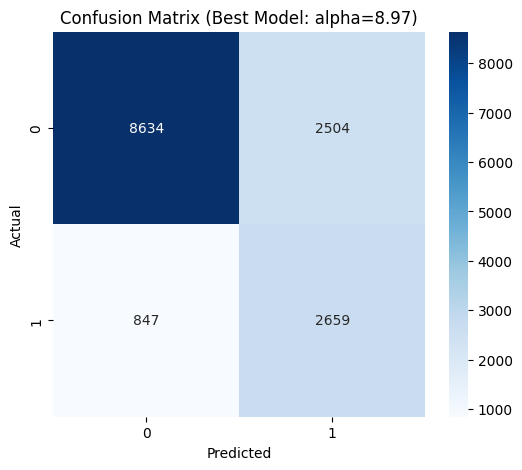

In [38]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bnb, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: alpha={best_alpha_bnb:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Support Vector Machine (SVM)**

In [39]:
# Define a reduced search space for SVM
search_space_svm = {
    'C': Real(0.1, 10, prior='log-uniform'),  # Narrower range for regularization
    'gamma': Real(1e-2, 0.1, prior='log-uniform'),  # Narrower range for gamma
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid'])  # Limit to two common kernels
}

# Perform Bayesian Optimization with fewer iterations and folds
bayes_search_svm = BayesSearchCV(
    SVC(probability=True),  
    search_space_svm,
    n_iter=5, 
    scoring='roc_auc',
    cv=3,  
    n_jobs=-1, 
    random_state=42  
)

# Fit the model
bayes_search_svm.fit(X_train, y_train)

# Get best parameters
best_params_svm = bayes_search_svm.best_params_
best_C_svm = best_params_svm['C']
best_gamma_svm = best_params_svm['gamma']
best_kernel_svm = best_params_svm['kernel']

print(f"Best Parameters (SVM Bayesian Search): C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, kernel={best_kernel_svm}")

Best Parameters (SVM Bayesian Search): C=0.78, gamma=0.08293, kernel=linear


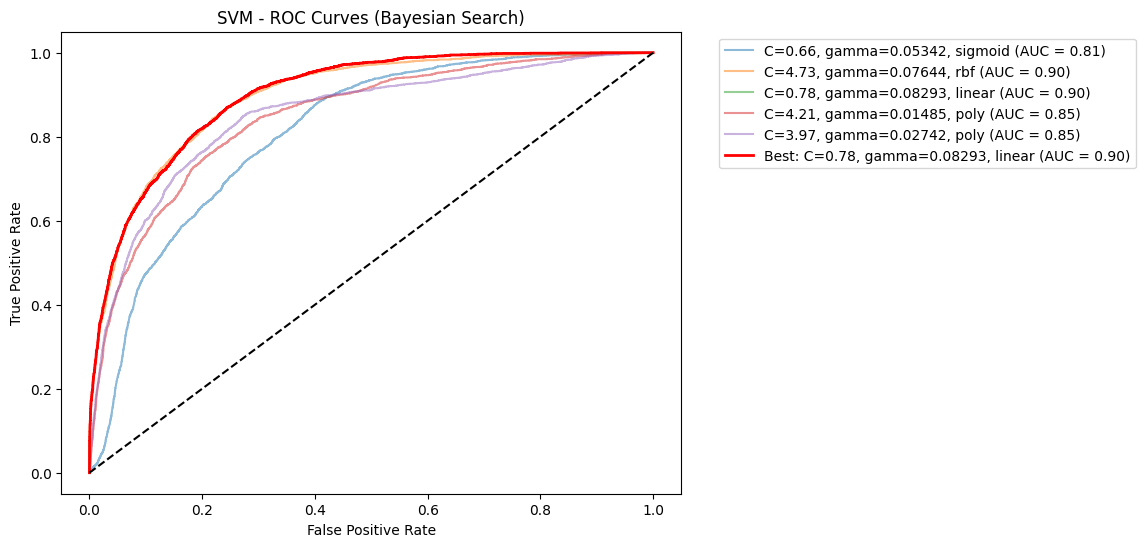

In [40]:
plt.figure(figsize=(8, 6))

all_models_svm = []
best_auc_svm = 0
best_fpr_svm, best_tpr_svm = None, None

for params in bayes_search_svm.cv_results_['params']:
    C_svm = params['C']
    gamma_svm = params['gamma']
    kernel_svm = params['kernel']

    # Train model
    model_svm = SVC(C=C_svm, gamma=gamma_svm, kernel=kernel_svm, probability=True)
    model_svm.fit(X_train, y_train)

    # Predictions
    y_proba_svm = model_svm.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)

    all_models_svm.append((C_svm, gamma_svm, kernel_svm, fpr_svm, tpr_svm, roc_auc_svm))

    # Highlight the best model
    if (C_svm == best_C_svm) and (gamma_svm == best_gamma_svm) and (kernel_svm == best_kernel_svm):
        best_auc_svm = roc_auc_svm
        best_fpr_svm, best_tpr_svm = fpr_svm, tpr_svm

    plt.plot(fpr_svm, tpr_svm, label=f"C={C_svm:.2f}, gamma={gamma_svm:.5f}, {kernel_svm} (AUC = {roc_auc_svm:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_svm, best_tpr_svm, linewidth=2, label=f"Best: C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, {best_kernel_svm} (AUC = {best_auc_svm:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [41]:
# Train the best model separately
start_time_svm = timer()
best_model_svm = SVC(C=best_C_svm, gamma=best_gamma_svm, kernel=best_kernel_svm, probability=True)
best_model_svm.fit(X_train, y_train)
training_time_svm = timer() - start_time_svm

# Predictions
y_pred_svm = best_model_svm.predict(X_test)
y_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Specificity (True Negative Rate)
tn_svm, fp_svm, fn_svm, tp_svm = conf_matrix_svm.ravel()
specificity_svm = tn_svm / (tn_svm + fp_svm)

# ROC Curve for best model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Print Evaluation Results
print("\nSVM Classification Report (Best Model):")
print(classification_report(y_test, y_pred_svm))
print(f"Specificity (True Negative Rate): {specificity_svm:.4f}")
print(f"Training Time: {training_time_svm:.4f} seconds")
print(f"ROC AUC: {roc_auc_svm:.4f}")


SVM Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11138
           1       0.74      0.60      0.66      3506

    accuracy                           0.85     14644
   macro avg       0.81      0.76      0.78     14644
weighted avg       0.85      0.85      0.85     14644

Specificity (True Negative Rate): 0.9325
Training Time: 212.0531 seconds
ROC AUC: 0.8992


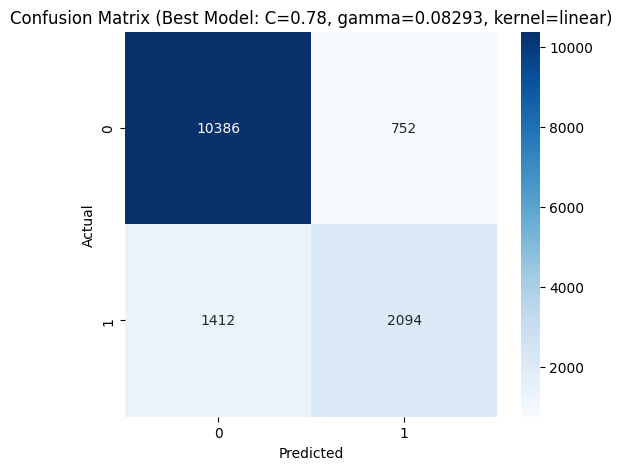

In [42]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, kernel={best_kernel_svm})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Neural Network: Multilayer Perceptron (MLP)**

In [43]:
# Define search space for MLP (as a parameter grid)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Tuple options
    'activation': ['relu', 'tanh', 'logistic'],  # Valid activation functions
    'learning_rate_init': [1e-3, 1e-2],  # Discrete values instead of continuous range
    'max_iter': [100],  # Discrete values
}

# Initialize MLPClassifier
mlp = MLPClassifier(solver='adam', random_state=42)

# Perform Grid Search
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='roc_auc',  # ROC AUC for binary classification
    cv=3,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
)

# Fit the model
grid_search_mlp.fit(X_train, y_train)

# Get best parameters
best_params_mlp = grid_search_mlp.best_params_
best_hidden_layer_sizes = best_params_mlp['hidden_layer_sizes']
best_activation = best_params_mlp['activation']
best_learning_rate = best_params_mlp['learning_rate_init']

# Print results
print(f"Best Parameters (MLP Grid Search): hidden_layer_sizes={best_hidden_layer_sizes}, "
      f"activation={best_activation}, learning_rate={best_learning_rate:.5f}")

Best Parameters (MLP Grid Search): hidden_layer_sizes=(100, 50), activation=tanh, learning_rate=0.00100


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


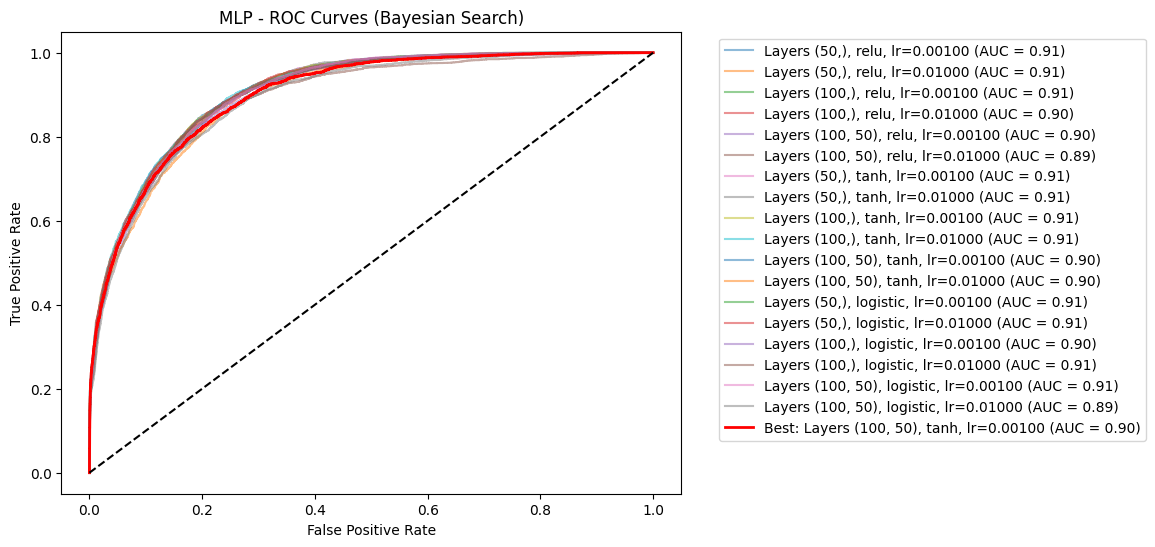

In [44]:
plt.figure(figsize=(8, 6))

all_models_mlp = []
best_auc_mlp = 0
best_fpr_mlp, best_tpr_mlp = None, None

for params in grid_search_mlp.cv_results_['params']:
    hidden_layer_sizes_mlp = params['hidden_layer_sizes']
    activation_mlp = params['activation']
    learning_rate_mlp = params['learning_rate_init']

    # Train model
    model_mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_mlp, 
                              activation=activation_mlp, 
                              learning_rate_init=learning_rate_mlp, 
                              solver='adam', 
                              max_iter=500,  # Increase the number of iterations
                              random_state=42)
    model_mlp.fit(X_train, y_train)

    # Predictions
    y_proba_mlp = model_mlp.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

    all_models_mlp.append((hidden_layer_sizes_mlp, activation_mlp, learning_rate_mlp, fpr_mlp, tpr_mlp, roc_auc_mlp))

    # Highlight the best model
    if (hidden_layer_sizes_mlp == best_hidden_layer_sizes) and (activation_mlp == best_activation) and (learning_rate_mlp == best_learning_rate):
        best_auc_mlp = roc_auc_mlp
        best_fpr_mlp, best_tpr_mlp = fpr_mlp, tpr_mlp

    plt.plot(fpr_mlp, tpr_mlp, label=f"Layers {hidden_layer_sizes_mlp}, {activation_mlp}, lr={learning_rate_mlp:.5f} (AUC = {roc_auc_mlp:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_mlp, best_tpr_mlp, linewidth=2, label=f"Best: Layers {best_hidden_layer_sizes}, {best_activation}, lr={best_learning_rate:.5f} (AUC = {best_auc_mlp:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [45]:
# Train the best MLP model separately
start_time_mlp = timer()
best_model_mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, 
                               activation=best_activation, 
                               learning_rate_init=best_learning_rate, 
                               solver='adam', random_state=42)
best_model_mlp.fit(X_train, y_train)
training_time_mlp = timer() - start_time_mlp

# Predictions
y_pred_mlp = best_model_mlp.predict(X_test)
y_proba_mlp = best_model_mlp.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

# Specificity (True Negative Rate)
tn_mlp, fp_mlp, fn_mlp, tp_mlp = conf_matrix_mlp.ravel()
specificity_mlp = tn_mlp / (tn_mlp + fp_mlp)

# ROC Curve for best model
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Print Evaluation Results
print("\nMLP Classification Report (Best Model):")
print(classification_report(y_test, y_pred_mlp))
print(f"Specificity (True Negative Rate): {specificity_mlp:.4f}")
print(f"Training Time: {training_time_mlp:.4f} seconds")
print(f"ROC AUC: {roc_auc_mlp:.4f}")

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11138
           1       0.74      0.61      0.67      3506

    accuracy                           0.85     14644
   macro avg       0.81      0.77      0.79     14644
weighted avg       0.85      0.85      0.85     14644

Specificity (True Negative Rate): 0.9315
Training Time: 155.8218 seconds
ROC AUC: 0.9080


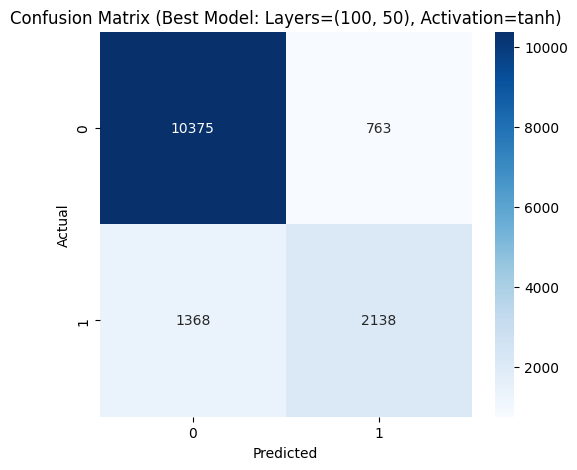

In [46]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: Layers={best_hidden_layer_sizes}, Activation={best_activation})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Evaluation Summary**

**Accuracy, Precision, Recall, Specificity, F1 Score and AUC**

Evaluation Metrics Comparison:
                    Model  Accuracy  Precision    Recall  Specificity  \
0           Decision Tree  0.858850   0.791414  0.557330     0.953762   
1           Random Forest  0.846695   0.699462  0.630633     0.914706   
2    Gaussian Naive Bayes  0.796845   0.662983  0.308043     0.950709   
3   Bernoulli Naive Bayes  0.771169   0.515011  0.758414     0.775184   
4  Support Vector Machine  0.852226   0.735770  0.597262     0.932483   
5   Multilayer Perceptron  0.854480   0.736987  0.609812     0.931496   

   F1 Score       AUC  
0  0.654059  0.905696  
1  0.663267  0.890371  
2  0.420643  0.833395  
3  0.613450  0.845113  
4  0.659320  0.899218  
5  0.667395  0.907958  


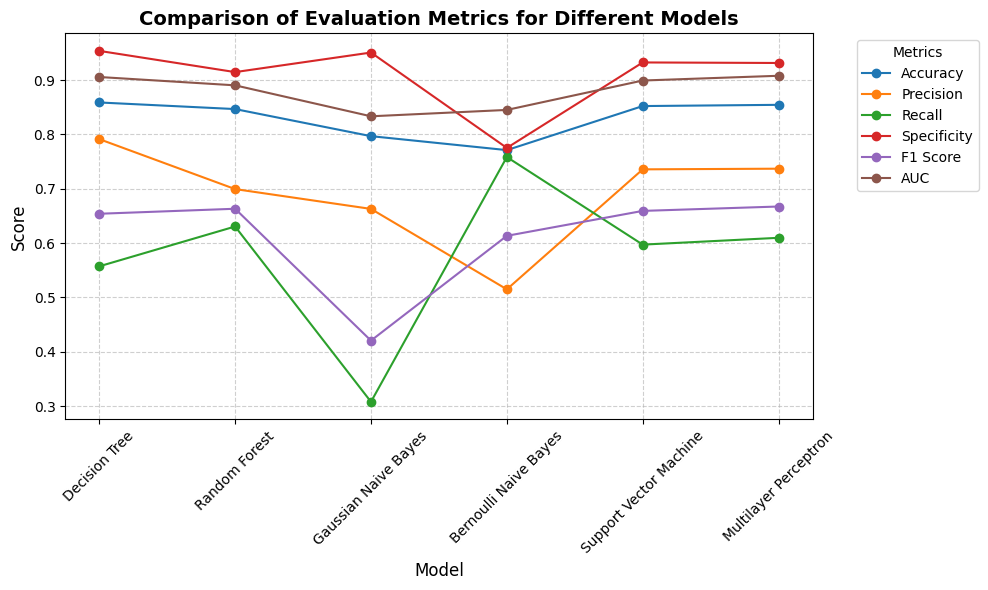

In [47]:
# Collecting metrics for each model
metrics_dict = {
    'Model': ['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'Bernoulli Naive Bayes', 'Support Vector Machine', 'Multilayer Perceptron'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gnb),
        accuracy_score(y_test, y_pred_bnb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_mlp)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gnb),
        precision_score(y_test, y_pred_bnb),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_mlp)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gnb),
        recall_score(y_test, y_pred_bnb),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_mlp)
    ],
    'Specificity': [
        specificity, specificity_rf, specificity_gnb, specificity_bnb, specificity_svm, specificity_mlp
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gnb),
        f1_score(y_test, y_pred_bnb),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_mlp)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_gnb),
        roc_auc_score(y_test, y_proba_bnb),
        roc_auc_score(y_test, y_proba_svm),
        roc_auc_score(y_test, y_proba_mlp)
    ]
}

# Creating a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics_dict)

# Print the evaluation metrics table
print("Evaluation Metrics Comparison:")
print(metrics_df)

# Set the index to 'Model' for easier plotting
metrics_df.set_index('Model', inplace=True)

# Plot the line chart
plt.figure(figsize=(10, 6))
for metric in metrics_df.columns:
    plt.plot(metrics_df.index, metrics_df[metric], marker='o', linestyle='-', label=metric)

# Formatting
plt.title('Comparison of Evaluation Metrics for Different Models', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True, linestyle='--', alpha=0.6)  # Add a light grid for readability
plt.tight_layout()

# Show the plot
plt.show()

**Confusion Matrix**

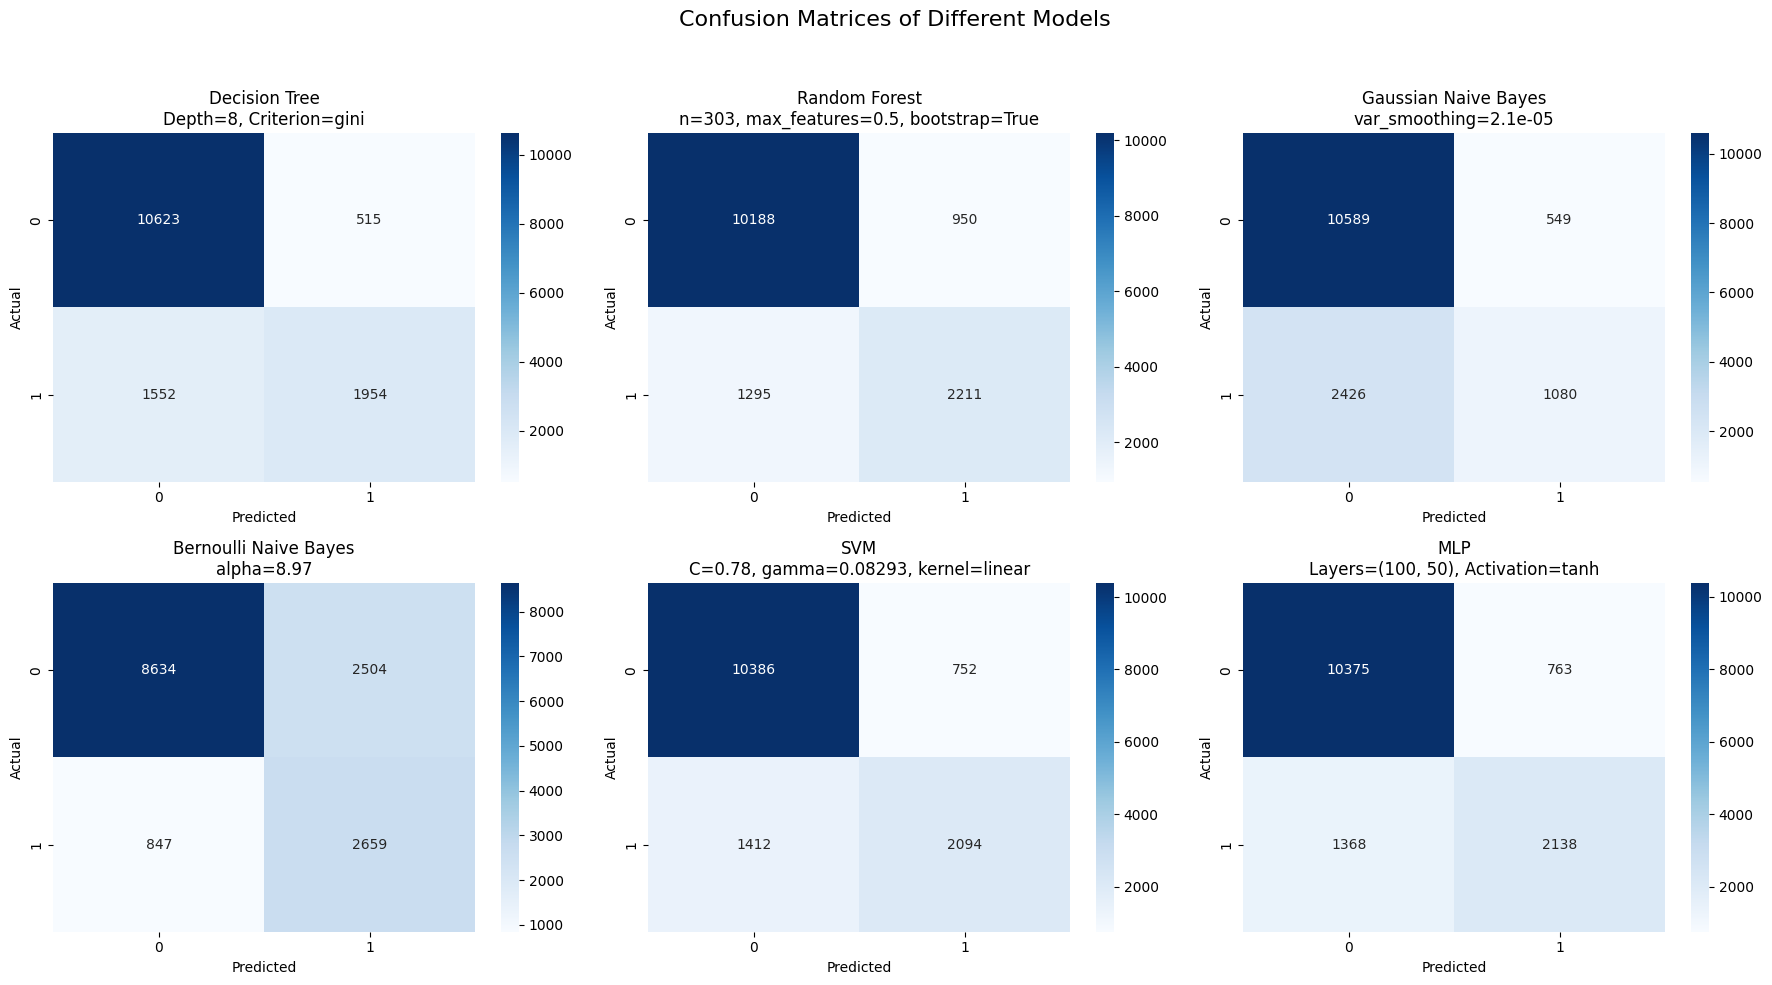

In [48]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices of Different Models', fontsize=16)

# List of confusion matrices and titles
conf_matrices = [
    (conf_matrix_decision_tree, f'Decision Tree\nDepth={best_max_depth_dt}, Criterion={best_criterion_dt}'),
    (conf_matrix_rf, f'Random Forest\nn={best_n_estimators}, max_features={best_max_features}, bootstrap={best_bootstrap}'),
    (conf_matrix_gnb, f'Gaussian Naive Bayes\nvar_smoothing={best_var_smoothing:.1e}'),
    (conf_matrix_bnb, f'Bernoulli Naive Bayes\nalpha={best_alpha_bnb:.2f}'),
    (conf_matrix_svm, f'SVM\nC={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, kernel={best_kernel_svm}'),
    (conf_matrix_mlp, f'MLP\nLayers={best_hidden_layer_sizes}, Activation={best_activation}')
]

# Plot each confusion matrix
for ax, (matrix, title) in zip(axes.flatten(), conf_matrices):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Adjust layout for better visualization
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Running time**


Training Time Summary:
Decision Tree: 0.0615 seconds
Random Forest: 17.3846 seconds
Gaussian Naive Bayes: 0.0097 seconds
Bernoulli Naive Bayes: 0.0252 seconds
SVM: 212.0531 seconds
MLP: 155.8218 seconds


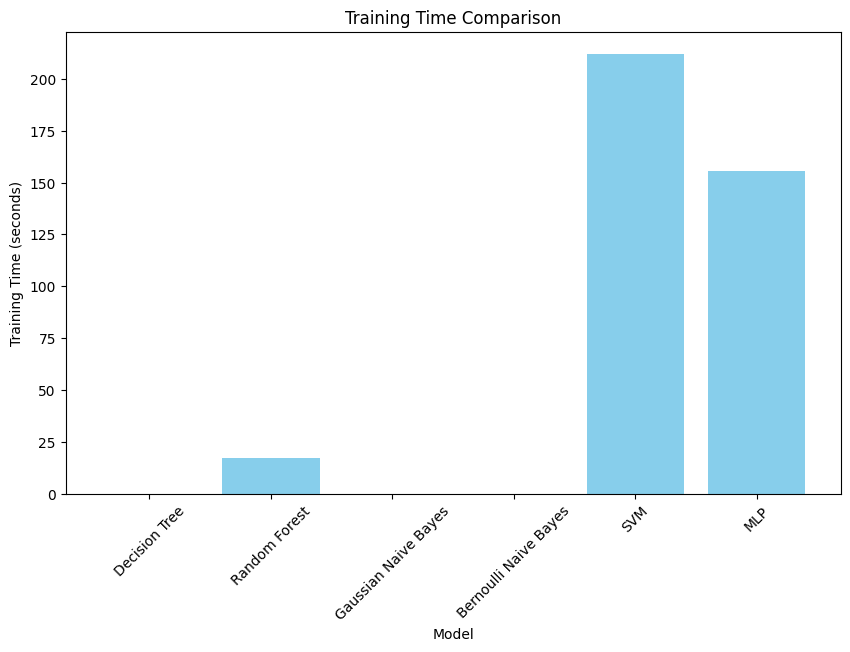

In [49]:
# Summarize training times
training_times = {
    "Decision Tree": training_time_dt,
    "Random Forest": training_time_rf,
    "Gaussian Naive Bayes": training_time_gnb,
    "Bernoulli Naive Bayes": training_time_bnb,
    "SVM": training_time_svm,
    "MLP": training_time_mlp
}

# Print training times
print("\nTraining Time Summary:")
for model, time_taken in training_times.items():
    print(f"{model}: {time_taken:.4f} seconds")

# Visualize training times
plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)
plt.show()

# **Comparison and analysis on evaluation metrics**

## **Comparison of model performance**

### **Accuracy & AUC**

- The **Decision Tree (85.89%)**, **Multilayer Perception (85.45%)** and **Support Vector Machine (85.22%)** have the highest accuracy $\rightarrow$ These models make the most correct predictions overall

- **Gaussian Naive Bayes (79.68%)** and **Bernoulli Naive Bayes (77.12%)** have noticeably lower accuracy $\rightarrow$ struggle more with classification (maybe the parameters are still not the best or the model does not suit for this dataset)

- When looking at AUC which measures how well the model distinguishes between positive and negative cases:
    - Two models are **Multilayer Perception (0.908)** and **Decision Tree (0.906)** which have the best *discrimination* ability
    - **Gaussian Naive Bayes (0.833)** has the lowest AUC (also low at accuracy metric) $\rightarrow$ struggles more to differentiate between classes

### **Positive and Negative class performance**

**Precision (Minimizing False Positives)** -[how many of the predicted positive cases were actually positive]

- The **decision tree (0.791)** and **Gaussian Naive Bayes (0.737)** performs well in precision $\rightarrow$ when it predicts a positive case, it's correct more often than the other models

- The lowest precision is **Bernoulli Naive Bayes (0.515)** $\rightarrow$ it frequently predicts positive cases incorrectly so this is not be ideal for applications where false positive are a concern

**Recall (Capturing Actual Positives)** - [how many actual positive cases were correctly identified by the model]

- **Bernoulli Naive Bayes (0.758)** has the highest recall $\rightarrow$ captures the most actual positives. In contrast, **Gaussian Naive Bayes (0.3080)** has the worst recall $\rightarrow$ it misses a large number of actual positive cases $\rightarrow$ too conservative in predicting positive outcomes

**Specificity (Correctly Identifying Negatives)** - [how well a model identifies negative cases]

- **Decision Tree (0.954)** and **Gaussian Naive Bayes (0.951)** have the highest specificity $\rightarrow$ excellent at recognizing negative cases. This comes at the cost of recall, as seen above. In contrast, the **Bernoulli Naive Bayes (0.775)** has the lowest specificity, meaning it incorrectly classifies many negatives as positives.

**F1 Score (Balancing Precision and Recall)** - [precision and recall often have a trade-off, it helps find out a balance between them]

- **Multilayer Perceptron (0.6673)** and **Random Forest (0.6632)** have the best F1 scores $\rightarrow$ a good balance between precision and recall. In the other hand, **Gaussian Naive Bayes (0.4206)** has the worst F1 score $\rightarrow$ its poor recall significantly affects its overall effectiveness

## **Confusion matrix analysis**

With **decision tree**, it performs well with low false positives (515) $\rightarrow$ correctly identifies negative cases most of the time. But it still misses many actual positive cases when the false negatives are relatively high (1552)

$\Rightarrow$ This indicates that while the model is precise when it predicts positive, it is **not the best at capturing all positive cases**

With **random forest**, the false positive are slightly higher than in the decision tree $\rightarrow$ slightly worse at avoiding incorrect positive classifications. Besides that, false negatives are lower than in the decision tree $\rightarrow$ it captures more actual posititve

$\Rightarrow$ This model is better coverage of positive cases but at the cost of a slightly higher false positive rate of decision tree

With **Gaussian Naive Bayes**, the high false negatives indicates that the model fails to capture a large number of positives cases while the false positive are very low which indicating it is very conservative in predicting positives

$\Rightarrow$ This model is **biased towards predicting negatives** which lead to a high specificity but poor recall

With **Bernoulli Naive Bayes**, the model frequently misclassifies negative cases as positive (very high false positives) but correctly captures more actual positives (very low false negatives)

$\Rightarrow$ This model has high recall but poor precision, meaning it is useful when capturing all positive cases is important, even at the cost of more false positives

With **Support Vector Machine**, the model is fairly precise and has a moderate number of missed positive cases

$\Rightarrow$ The model balances recall and precision well

With **Multilayer perceptron (MLP)**, the false positives are low as similar to SVM $\rightarrow$ it does well at precision. But the false negatives are slightly lower than SVM so it can captures a bit more actual positives

$\Rightarrow$ This model also maintains a **good balance between recall and precision**

# **Comparison of runtime and scalability**

 **Trade-offs Between Speed and Prediction Quality**

| Model | Training Time | Accuracy | Best For | Trade-Offs |
|--------|---------------|------------|------------|----------------|
| **Decision Tree** | 0.0615s | **85.89%** | Fast, interpretable models | May overfit without pruning |
| **Random Forest** | 17.38s | 84.67% | Generalization, good recall | Slow training, resource-heavy |
| **Gaussian Naive Bayes** | 0.0097s | 79.68% | Large datasets, real-time prediction | Poor recall and F1-score |
| **Bernoulli Naive Bayes** | 0.0252s | 77.11% | High recall tasks (e.g., fraud detection) | Low precision, high false positives |
| **SVM** | 212.05s | 85.22% | Small, high-dimensional datasets | Slowest training, not scalable |
| **MLP** | 155.82s | 85.45% | Complex patterns, deep learning | High computational cost |

# **Recommend the best model(s) based on evaluation metrics, computational cost, and dataset characteristics**



<div align='center'>

| **Scenario** | **Best Model** | **Reasoning** |
|-------------|-------------|-------------|
| **Balanced Performance (Best Overall)** | Multilayer Perceptron (MLP)  / SVM | High F1-score, accuracy, and AUC. Strong generalization ability. |
| **High Precision (Avoid False Positives)** | Decision Tree / Gaussian Naive Bayes | Fewer false positives, high specificity. Useful for fraud detection, medical diagnosis, etc. |
| **High Recall (Avoid False Negatives)** | Bernoulli Naive Bayes / Random Forest | Captures most positives. Useful for disease detection, where missing a case is critical. |
| **High Specificity (Avoid False Alarms)** | Gaussian Naive Bayes | Conservative predictions, avoids false positives. May be useful in risk-sensitive applications. |
| **Best for Scalability & Speed** | Decision Tree | Fast training with high accuracy. Ideal for large datasets. |
| **Best AUC (Class Separation Ability)** | MLP / Decision Tree | Best discrimination between positive and negative cases. |

</div>

Some scenarios to consider:
- If training time and scalability are concerns $\rightarrow$ Decision Tree
- If explainability and robustness are needed $\rightarrow$ Random Forest.


**Conclusion** - MLP and Decision Tree are the most effective models overall, with Decision Tree being the best choice for fast, reliable predictions.